In [1]:
import numpy as np
from pybasicbayes.distributions import Gaussian
from src.hmm_base_class import _HMM
from src.hmm_coord_descent import VB_HMM
import matplotlib.pyplot as plt
import time
import math

/Users/askates/anaconda3/envs/python3.5/lib/python3.5/site-packages/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/Users/askates/anaconda3/envs/python3.5/lib/python3.5/site-packages/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


In [13]:
N = 10000
D = 2
K = 4

class HMM:
    def __init__(self):
        pass

    def simulate(self,nSteps):
        def drawFromMultinomial(t):
            return np.where(np.random.multinomial(1,t) == 1)[0][0]

        states = np.zeros(nSteps, dtype=np.int)

        # Initial values. For sake of simplicity, there is only one initial prob vector
        states[0] = drawFromMultinomial(self.pi)

        for i in range(1,nSteps):
            states[i] = drawFromMultinomial(self.t[states[i-1],:])
        return states

hmm = HMM()
hmm.pi = np.array([0.25, 0.25, 0.25, 0.25])
hmm.t = np.array([
    [0.97, 0.03, 0.0, 0.0],
    [0.00, 0.97, 0.03, 0.],
    [0.0, 0.0, 0.97, 0.3],
    [0.3, 0.0, 0.0, 0.97]])
state_seq = hmm.simulate(N)

mu = np.array([[0., 0.],[-15., 5],[10., 7],[-4., -15]])
distributions = []
for i in range(K):
    distributions.append(np.random.multivariate_normal(mu[i], np.eye(D), N).T)

data = np.zeros([N, D])
for n, s in enumerate(state_seq):
    data[n]  = distributions[s][:, n]

# Initial and transition matrix prior
A_0 = np.ones(K*K).reshape((K,K))
pi_0 = np.ones(K)

# Emission prior
mu_0 = np.zeros(D)
sigma_0 = np.eye(D)
kappa_0 = 0.01
nu_0 = 4

prior_emissions = []
for i in range(K):
    prior_emissions.append(Gaussian(mu_0=mu_0, sigma_0=sigma_0, kappa_0=kappa_0,
                                    nu_0=nu_0))

/Users/askates/anaconda3/envs/python3.5/lib/python3.5/site-packages/pybasicbayes/util/stats.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)


In [30]:
hmm = VB_HMM(data, pi_0, A_0, prior_emissions, max_iter=100)

In [15]:
hmm.infer()

Iteration 0
Current lb: -30720888356.1759 Previous lb: 10000000000.0
Iteration 1
Current lb: -723344663.7356794 Previous lb: -30720888356.1759
Iteration 2
Current lb: -723565160.9722444 Previous lb: -723344663.7356794
Iteration 3
Current lb: -723793703.8155308 Previous lb: -723565160.9722444
Iteration 4
Current lb: -724027612.2734951 Previous lb: -723793703.8155308
Iteration 5
Current lb: -724265672.5528283 Previous lb: -724027612.2734951
Iteration 6
Current lb: -724507144.0207692 Previous lb: -724265672.5528283
Iteration 7
Current lb: -724751517.9190073 Previous lb: -724507144.0207692
Iteration 8
Current lb: -724998420.4868923 Previous lb: -724751517.9190073
Iteration 9
Current lb: -725247564.5675029 Previous lb: -724998420.4868923
Iteration 10
Current lb: -725498722.2412258 Previous lb: -725247564.5675029
Iteration 11
Current lb: -725751708.0279977 Previous lb: -725498722.2412258
Iteration 12
Current lb: -726006367.9517604 Previous lb: -725751708.0279977
Iteration 13
Current lb: -726

(False, array([ -3.07208884e+10,  -7.23344664e+08,  -7.23565161e+08,
         -7.23793704e+08,  -7.24027612e+08,  -7.24265673e+08,
         -7.24507144e+08,  -7.24751518e+08,  -7.24998420e+08,
         -7.25247565e+08,  -7.25498722e+08,  -7.25751708e+08,
         -7.26006368e+08,  -7.26262572e+08,  -7.26520209e+08,
         -7.26779184e+08,  -7.27039411e+08,  -7.27300817e+08,
         -7.27563336e+08,  -7.27826909e+08,  -7.28091484e+08,
         -7.28357012e+08,  -7.28623451e+08,  -7.28890760e+08,
         -7.29158903e+08,  -7.29427847e+08,  -7.29697561e+08,
         -7.29968016e+08,  -7.30239185e+08,  -7.30511045e+08,
         -7.30783572e+08,  -7.31056744e+08,  -7.31330542e+08,
         -7.31604946e+08,  -7.31879938e+08,  -7.32155502e+08,
         -7.32431622e+08,  -7.32708282e+08,  -7.32985469e+08,
         -7.33263169e+08,  -7.33541369e+08,  -7.33820057e+08,
         -7.34099221e+08,  -7.34378851e+08,  -7.34658935e+08,
         -7.34939463e+08,  -7.35220427e+08,  -7.35501816e+08,
 

In [25]:
def plot_emissions(data, prior_emissions, var_emissions):
    plt.figure()
    plt.scatter(data[:,0], data[:,1])
    for G in prior_emissions:
        plt.scatter(*G.mu_mf, color='green')
    for G in var_emissions:
        plt.scatter(*G.mu_mf, color='red')

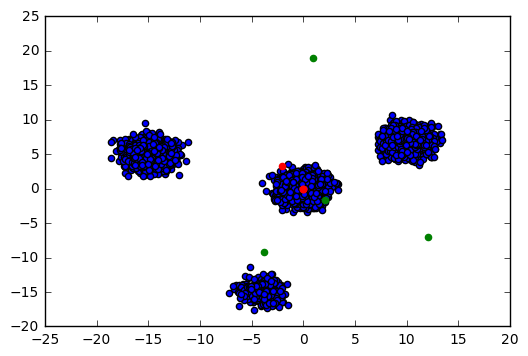

In [26]:
plot_emissions(hmm._obs, prior_emissions, hmm._var_emit)
plt.show()

In [42]:
print(hmm._ln_lik)
print(hmm._ln_alpha)
print(hmm._aux_pi)

[[-1477.73533889  -610.70241009  -777.81416676 -1744.15961218]
 [-1595.64415752  -610.65258376  -978.27950757 -2176.83705924]
 [ -113.09646696  -263.70119955 -1551.10715907  -771.34918681]
 ..., 
 [ -130.07167853  -257.78512604 -1875.83891189 -1013.08323801]
 [ -106.60562359  -246.13906072 -1246.56949405  -832.58259505]
 [ -131.93845374  -294.06735312 -1854.84183212  -643.62437564]]
[[ -1.48138558e+03  -6.14352648e+02  -7.81464404e+02  -1.74780985e+03]
 [ -2.09573822e+03  -1.22870530e+03  -1.39581705e+03  -2.36216250e+03]
 [ -2.71009087e+03  -1.84305794e+03  -2.01016970e+03  -2.97651515e+03]
 ..., 
 [ -6.14316481e+06  -6.14229777e+06  -6.14246488e+06  -6.14343123e+06]
 [ -6.14377916e+06  -6.14291213e+06  -6.14307924e+06  -6.14404558e+06]
 [ -6.14439351e+06  -6.14352648e+06  -6.14369359e+06  -6.14465994e+06]]
[-3.65023771 -3.65023771 -3.65023771 -3.65023771]


In [31]:
hmm._local_update()

In [28]:
hmm._global_update()

In [29]:
hmm._marginal

array([[  3.43446504e-268,   1.00000000e+000,   3.43446504e-268,
          3.43446504e-268],
       [  1.36218926e-275,   1.00000000e+000,   1.36218926e-275,
          1.36218926e-275],
       [  1.36218926e-275,   1.00000000e+000,   1.36218926e-275,
          1.36218926e-275],
       ..., 
       [  1.36218926e-275,   1.00000000e+000,   1.36218926e-275,
          1.36218926e-275],
       [  1.36218926e-275,   1.00000000e+000,   1.36218926e-275,
          1.36218926e-275],
       [  5.24221974e-274,   1.00000000e+000,   5.24221974e-274,
          5.24221974e-274]])

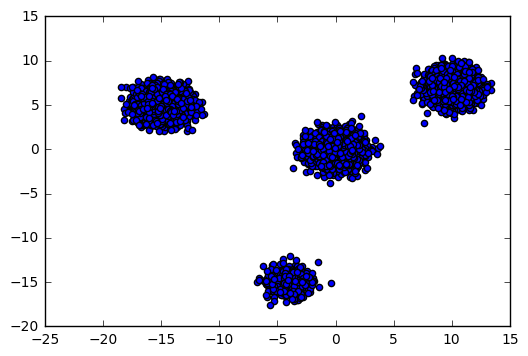

In [26]:
plt.scatter(data[:,0], data[:,1])
plt.show()

In [62]:
a = np.array([[0,0,0,0],[1,1,1,1],[2,2,2,2]])
b = np.array([1,1,1,1])

In [64]:
np.sum(a + b, axis=1

array([ 4,  8, 12])